In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import tree
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

import gc
from tqdm import tqdm

In [2]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [3]:
def na_check(data):
    check = np.round(data.isna().mean().sort_values(ascending=False),2)
    return check

In [4]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [5]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = pd.read_csv('data/cleaned_data')

In [7]:
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/76 [00:00<?, ?it/s]

Memory usage of dataframe is 1009.53 MB


100%|██████████| 76/76 [00:07<00:00, 10.76it/s]


Memory usage after optimization is: 521.368 MB
Decreased by 48.4%


,Unnamed: 0,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,42536,10129454,12000.0,36 months,10.99%,392.750,B,B2,Project Manager,4 years,...,0.0,4.0,100.0000,0.0,0.0,7137.0,18100.0,0.0,N,N
1,42537,10149488,4800.0,36 months,10.99%,157.125,B,B2,Surgical Technician,2 years,...,0.0,0.0,100.0000,0.0,0.0,4136.0,25700.0,0.0,N,N
2,42538,10149342,27056.0,36 months,10.99%,885.500,B,B2,Team Leadern Customer Ops & Systems,10+ years,...,0.0,1.0,100.0000,0.0,0.0,70186.0,35700.0,33054.0,N,N
3,42539,10148122,12000.0,36 months,7.62%,374.000,A,A3,Systems Engineer,3 years,...,0.0,3.0,100.0000,0.0,0.0,46738.0,14800.0,53404.0,N,N
4,42540,10129477,14000.0,36 months,12.85%,470.750,B,B4,Assistant Director - Human Resources,4 years,...,0.0,0.0,78.6250,1.0,0.0,17672.0,3900.0,27340.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741058,2925488,102556443,24000.0,60 months,23.99%,690.500,E,E2,Senior Escrow Officer,< 1 year,...,1.0,2.0,87.5000,1.0,1.0,60812.0,28200.0,64422.0,N,N
1741059,2925489,102653304,10000.0,36 months,7.99%,313.250,A,A5,Rn,10+ years,...,0.0,2.0,92.6250,0.0,0.0,55863.0,34800.0,70203.0,N,N
1741060,2925490,102628603,10048.0,36 months,16.99%,358.250,D,D1,Sales Associate,8 years,...,0.0,5.0,95.1875,0.0,0.0,14300.0,9000.0,0.0,N,N
1741061,2925491,102196576,6000.0,36 months,11.44%,197.750,B,B4,Contact input,5 years,...,0.0,1.0,94.3750,0.0,0.0,26201.0,8100.0,34076.0,N,N


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741063 entries, 0 to 1741062
Data columns (total 76 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Unnamed: 0                  int32  
 1   id                          int32  
 2   loan_amnt                   float16
 3   term                        object 
 4   int_rate                    object 
 5   installment                 float16
 6   grade                       object 
 7   sub_grade                   object 
 8   emp_title                   object 
 9   emp_length                  object 
 10  home_ownership              object 
 11  annual_inc                  float32
 12  verification_status         object 
 13  issue_d                     object 
 14  loan_status                 object 
 15  pymnt_plan                  object 
 16  purpose                     object 
 17  title                       object 
 18  zip_code                    object 
 19  addr_state           

([<matplotlib.axis.YTick at 0x1b36e6f6d90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

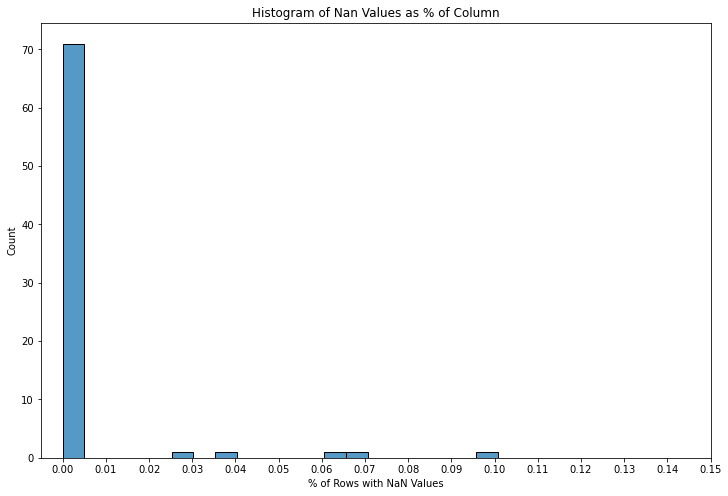

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data=df.isna().mean(),bins=20)
plt.xticks(np.linspace(0,.15,16))
plt.title("Histogram of Nan Values as % of Column")
plt.xlabel('% of Rows with NaN Values')
plt.yticks(np.linspace(0,70,8))

In [10]:
na_check(df).head(5)

mths_since_recent_inq    0.10
emp_title                0.07
emp_length               0.06
num_tl_120dpd_2m         0.04
mo_sin_old_il_acct       0.03
dtype: float64

In [8]:
mths_weights = list(df['mths_since_recent_inq'].value_counts(normalize=True,dropna=True))
mths_vals = list(df['mths_since_recent_inq'].value_counts(normalize=True,dropna=True).index)


In [9]:
df['mths_since_recent_inq'] = df['mths_since_recent_inq'].apply(lambda x: 
                                                                np.random.choice(mths_vals,p=mths_weights) if np.isnan(x) else x)

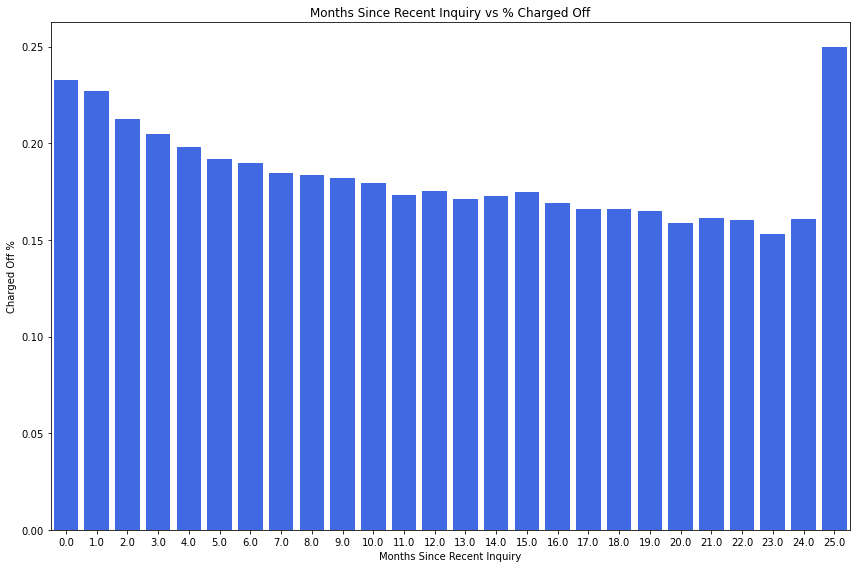

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
charge_off_rates = df.groupby('mths_since_recent_inq')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='royalblue', saturation=1,)
plt.xlabel('Months Since Recent Inquiry')
plt.ylabel('Charged Off %')
plt.title('Months Since Recent Inquiry vs % Charged Off')

plt.tight_layout()

Graph shows us that overtime if there hasnt been an inquiry then they are less likely to charge off their loan

In [10]:
#Too many unique titles to run as dummy variables as shown below 410k will drop
df.drop(columns='emp_title',axis=1,inplace=True)

In [26]:
df['emp_length'].value_counts(dropna=False)

10+ years    577115
2 years      157469
< 1 year     143287
3 years      139470
1 year       113914
NaN          109077
5 years      107285
4 years      103825
6 years       79175
8 years       74087
7 years       73084
9 years       63275
Name: emp_length, dtype: int64

In [11]:
emp_length_weight = list(df['emp_length'].value_counts(normalize=True,dropna=True))
emp_len_index = list(df['emp_length'].value_counts(normalize=True,dropna=True).index)

In [12]:
df['emp_length'].fillna(value='x',inplace=True)

In [13]:
df['emp_length'] = df['emp_length'].apply(lambda x: np.random.choice(emp_len_index,p=emp_length_weight) if x == "x" else x)

In [15]:
#dropping sympols before converting to int
df['emp_length'] = df['emp_length'].apply(lambda x: str(x).replace('+','').replace('<','').replace(' years','').replace(' year','').split())

In [16]:
df['emp_length'] = df['emp_length'].apply(lambda x: int(x[0]) )

In [17]:
df['emp_length']

0           4
1           2
2          10
3           3
4           4
           ..
1741058     1
1741059    10
1741060     8
1741061     5
1741062     4
Name: emp_length, Length: 1741063, dtype: int64

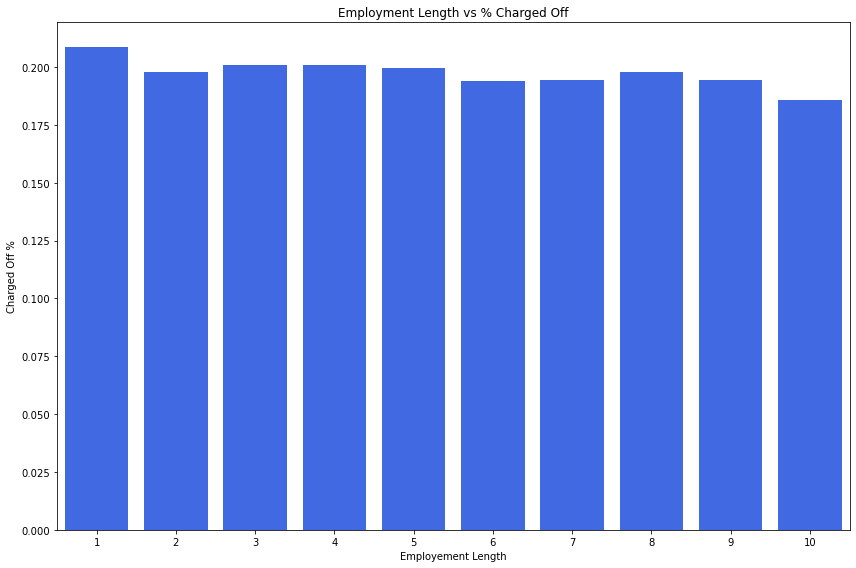

In [49]:
fig,ax = plt.subplots(figsize=(12,8))
charge_off_rates = df.groupby('emp_length')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='royalblue', saturation=1,)
plt.xlabel('Employement Length')
plt.ylabel('Charged Off %')
plt.title('Employment Length vs % Charged Off')

plt.tight_layout()

In [50]:
na_check(df)

mo_sin_old_il_acct       0.03
last_pymnt_d             0.00
dti                      0.00
last_credit_pull_d       0.00
zip_code                 0.00
                         ... 
delinq_amnt              0.00
mo_sin_old_rev_tl_op     0.00
mo_sin_rcnt_rev_tl_op    0.00
mo_sin_rcnt_tl           0.00
Unnamed: 0               0.00
Length: 75, dtype: float64

In [22]:
column_info('num_tl_120dpd_2m')

'Number of accounts currently 120 days past due (updated in past 2 months)'

In [24]:
df['num_tl_120dpd_2m'].value_counts(normalize=True)

0.0    1673721
NaN      66211
1.0       1085
2.0         40
3.0          4
6.0          1
4.0          1
Name: num_tl_120dpd_2m, dtype: int64

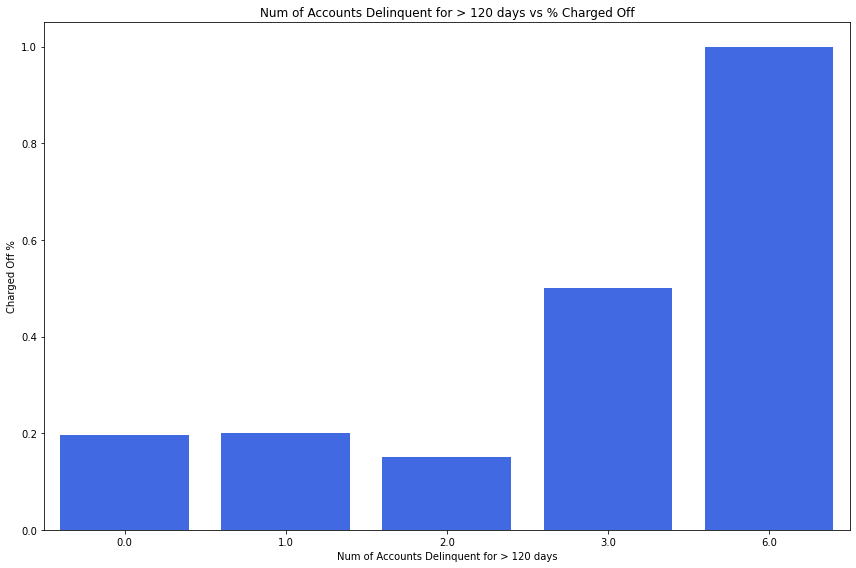

In [48]:
fig,ax = plt.subplots(figsize=(12,8))
charge_off_rates = df.groupby('num_tl_120dpd_2m')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='royalblue', saturation=1,)
plt.xlabel('Num of Accounts Delinquent for > 120 days')
plt.ylabel('Charged Off %')
plt.title('Num of Accounts Delinquent for > 120 days vs % Charged Off')

plt.tight_layout()

In [26]:
p = list(df['num_tl_120dpd_2m'].value_counts(normalize=True,dropna=True))
a = list(df['num_tl_120dpd_2m'].value_counts(normalize=True,dropna=True).index)

In [27]:
df['num_tl_120dpd_2m'] = df['num_tl_120dpd_2m'].apply(lambda x: np.random.choice(a,p=p) if np.isnan(x)  else x)

In [ ]:
df['']

<AxesSubplot:xlabel='mo_sin_old_il_acct', ylabel='loan_status'>

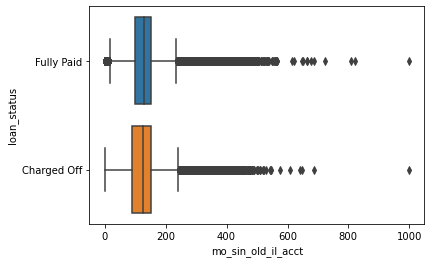

In [42]:
sns.boxplot(x='mo_sin_old_il_acct',y='loan_status',data=df)

In [53]:
column_info('mo_sin_old_il_acct')

'Months since oldest bank installment account opened'

<AxesSubplot:xlabel='mo_sin_old_il_acct', ylabel='Count'>

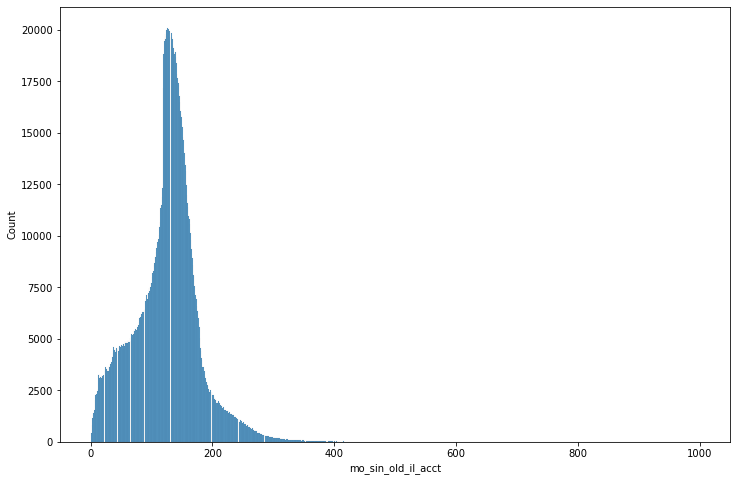

In [59]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(df.loc[df['mo_sin_old_il_acct'].notnull(), 'mo_sin_old_il_acct'], kde=False)

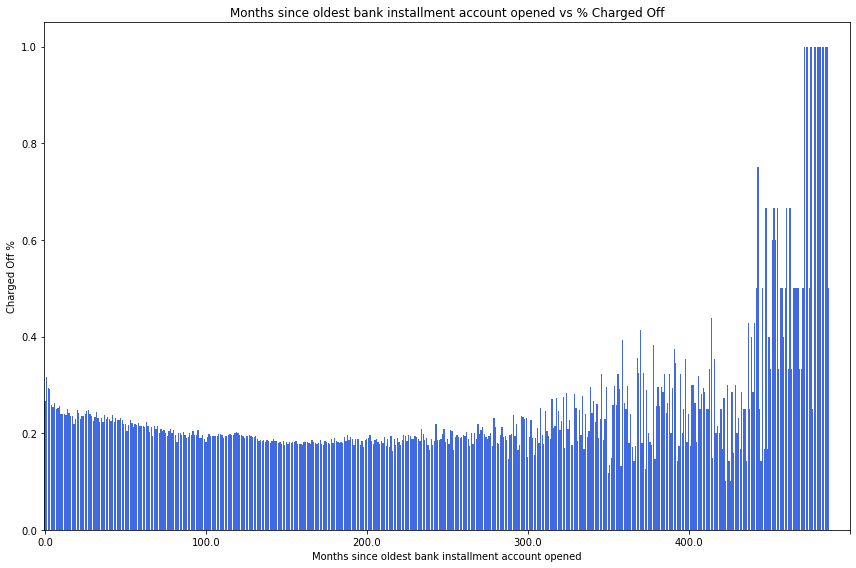

In [57]:
fig,ax = plt.subplots(figsize=(12,8))
charge_off_rates = df.groupby('mo_sin_old_il_acct')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='royalblue', saturation=1,)
plt.xlabel(column_info('mo_sin_old_il_acct'))
plt.ylabel('Charged Off %')
plt.title(column_info('mo_sin_old_il_acct')+ ' vs % Charged Off')
plt.xticks(np.linspace(0,500,6))a
plt.tight_layout()

All values to right of 200 are extreme outliers so will not relevant. Also making determination on oldest bank installments of 33 years prior doesn't seem to make too much sense

In [63]:
df.drop(columns=['mo_sin_old_il_acct'],axis=1,inplace=True)

In [72]:
#for cols with insignificant amount of nas missing
df.dropna(inplace=True)

In [ ]:
df.to_csv('data/preprocessed.csv')